# Predicting rejection or acceptance of the claims

In [1]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib, matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the data
rowdata_df = pd.read_csv("../pharmacy_tx.csv")

In [3]:
print(rowdata_df.shape)
rowdata_df.head(100)

(13910244, 9)


,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay
0,2022-01-02,Pharmacy #6,G99.93,branded tanoclolol,725700,1UQC,NaN,False,13.39
1,2022-01-02,Pharmacy #42,U60.52,branded oxasoted,664344,NaN,52H8KH0F83K,False,7.02
2,2022-01-02,Pharmacy #37,Q85.91,branded cupitelol,725700,1UQC,NaN,False,13.39
3,2022-01-02,Pharmacy #30,U60.52,generic oxasoted,571569,KB38N,6BYJBW,False,10.84
4,2022-01-02,Pharmacy #18,N55.01,branded mamate,664344,NaN,ZX2QUWR,False,47.00
...,...,...,...,...,...,...,...,...,...
95,2022-01-02,Pharmacy #26,Q85.91,generic rulfalol,322463,T52GV,EVD4X5,False,4.63
96,2022-01-02,Pharmacy #15,I68.27,branded prazinib,322463,3O71UTS,NaN,False,12.22
97,2022-01-02,Pharmacy #1,I68.27,branded mule,96934,9D24,VC81HUO7ZD,True,0.00
98,2022-01-02,Pharmacy #49,U60.52,generic foxivelule,322463,NaN,HO8HUGL,False,5.95


In [4]:
rowdata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13910244 entries, 0 to 13910243
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   tx_date      object 
 1   pharmacy     object 
 2   diagnosis    object 
 3   drug         object 
 4   bin          int64  
 5   pcn          object 
 6   group        object 
 7   rejected     bool   
 8   patient_pay  float64
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 862.3+ MB


In [5]:
#rowdata_dropna_df=rowdata_df.dropna()
print(rowdata_df.shape)

(13910244, 9)


In [6]:
duplicate = rowdata_df[rowdata_df.duplicated()]

In [7]:
# number of duplicates in the raw data,
print(duplicate.shape)

(1348399, 9)


In [8]:
# drop duplicates if all columns matched
dropduplicate_df= rowdata_df.drop_duplicates()
print(dropduplicate_df.shape)

(12561845, 9)


In [9]:
# split drug into two new columns brand and drug_name 
dropduplicate_df[['brand', 'drug_name']] =dropduplicate_df.drug.str.split(expand=True)

/Users/dilhumarablat/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [10]:
# drop the drug column 
dropduplicate_df.drop(["drug"], axis =1, inplace =True)
dropduplicate_df.head(5)

/Users/dilhumarablat/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,tx_date,pharmacy,diagnosis,bin,pcn,group,rejected,patient_pay,brand,drug_name
0,2022-01-02,Pharmacy #6,G99.93,725700,1UQC,NaN,False,13.39,branded,tanoclolol
1,2022-01-02,Pharmacy #42,U60.52,664344,NaN,52H8KH0F83K,False,7.02,branded,oxasoted
2,2022-01-02,Pharmacy #37,Q85.91,725700,1UQC,NaN,False,13.39,branded,cupitelol
3,2022-01-02,Pharmacy #30,U60.52,571569,KB38N,6BYJBW,False,10.84,generic,oxasoted
4,2022-01-02,Pharmacy #18,N55.01,664344,NaN,ZX2QUWR,False,47.00,branded,mamate


In [11]:
# removing the claims in Janurary, because the Janurary is the momth most of the patient not met their diductable
NoJan_df = dropduplicate_df[dropduplicate_df['tx_date'] >= "2022-02-01"]
print(NoJan_df.shape)

(11629192, 10)


In [12]:
# check the columns in the new dataset
NoJan_df.columns.tolist()

['tx_date',
 'pharmacy',
 'diagnosis',
 'bin',
 'pcn',
 'group',
 'rejected',
 'patient_pay',
 'brand',
 'drug_name']

#### We have cleaned our dataset by dropping duplicates, and Janurary claims.
Now we can start feature engineering for our model. As we see in the rejected and accepted claims in the dataset which is unbalanced data, so we need to choose a model which can deal with unbalanced data. 

In [13]:
# see the rejected and accepted claims
NoJan_df.groupby(["rejected"]).count()

,tx_date,pharmacy,diagnosis,bin,pcn,group,patient_pay,brand,drug_name
rejected,,,,,,,,,
False,10656338,10656338,10656338,10656338,7943221,7654870,10656338,10656338,10656338
True,972854,972854,972854,972854,701839,713537,972854,972854,972854


# Balanced Random Forest Classifier which can deal with unbalanced data
In this section, we train a Balanced Random Forest Classifier to complete the folliowing steps:

1. Train the model using the training data.
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the imbalanced_classification_report from imbalanced-learn.
5. Print the feature importance sorted in descending order (most important feature to least important) along with the feature score

In [14]:
# Initial imports
from collections import Counter
from pathlib import Path
import plotly.express as px
# Import dependencies
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from seaborn import set_style
set_style("whitegrid")

In [15]:
# getting columns contains strings which we need to engineer for the model
df_str_columns = NoJan_df.select_dtypes(include=['object'])
for col in df_str_columns.columns:
    print(col)

tx_date
pharmacy
diagnosis
pcn
group
brand
drug_name


## Feature engineering
First we encoded binary data such as brand (branded, generic) and rejected (false or true) into 1 or 0 as numeric. Then, we have 6 columns are not numerical but categorical data, we need to get dummies from these columns for the model. Finally, we dropped target column (rejected) along with other columns tx_date and patient_pay. We dropped patient_pay because we have 0 payment for rejected claims which is independent feature that we can not use to train or model.

In [16]:
# using lableEncoder to assign brand and rejected into numerical values 
le = LabelEncoder()
NoJan_df1 = NoJan_df.copy()
NoJan_df1['brand'] = le.fit_transform(NoJan_df1['brand'])
NoJan_df1['rejected'] = le.fit_transform(NoJan_df1['rejected'])

In [17]:
# Create our features and get dummies
X = pd.get_dummies(NoJan_df1, columns= ["diagnosis", "pcn","group", 
                                 "drug_name"]).drop(["rejected","tx_date","pharmacy","patient_pay"],axis=1)

# Create our target
y = NoJan_df1['rejected']
X.head()

,bin,brand,diagnosis_A00.82,diagnosis_A13.39,diagnosis_A14.01,diagnosis_A22.87,diagnosis_A45.07,diagnosis_B03.27,diagnosis_B05.36,diagnosis_B42.10,...,drug_name_tanoclolol,drug_name_thiostasteglume,drug_name_tocilic,drug_name_tocrocin,drug_name_todiadianic,drug_name_tovane,drug_name_tricatripride,drug_name_tugesutin,drug_name_vivafastat,drug_name_vocopirin
1019813,691847,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1019814,322463,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1019815,691847,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1019816,160389,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1019817,322463,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Check the balance of our target values, 0 is accepted claims and 1 is the rejected
y.value_counts()

0    10656338
1      972854
Name: rejected, dtype: int64

In [19]:
# Import train test split function
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  train_size=0.25)

In [20]:
# Check balances and they are not balanced 
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 2664575, 1: 242723})
Counter({0: 7991763, 1: 730131})


## Resample the training data with the BalancedRandomForestClassifier

In [21]:
# Resample the training data with the BalancedRandomForestClassifier
# get time for execustion
from datetime import datetime
start_time = datetime.now()

from imblearn.ensemble import BalancedRandomForestClassifier
BalancedRFC_model = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
BalancedRFC_model= BalancedRFC_model.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:16:15.595889


In [22]:
# Calculated the balanced accuracy score with test data
from datetime import datetime
start_time = datetime.now()

y_pred = BalancedRFC_model.predict(X_test)
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:22:17.866845


In [28]:
balanced_accuracy_score(y_test, y_pred)

0.877536937074151

In [23]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [24]:
# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,6052388,1939375
Actual 1,1646,728485


In [25]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.76      1.00      0.86      0.87      0.74   7991763
          1       0.27      1.00      0.76      0.43      0.87      0.77    730131

avg / total       0.94      0.78      0.98      0.83      0.87      0.74   8721894



In [26]:
# List the features 
features = BalancedRFC_model.feature_importances_
features

array([1.68208674e-02, 2.07290695e-01, 7.28657584e-07, 1.52364459e-04,
       2.20028136e-04, 3.57653307e-06, 5.20013999e-05, 2.68173180e-04,
       2.95279929e-04, 1.27564721e-04, 3.08365433e-03, 8.97004456e-05,
       5.60798304e-05, 4.50240105e-04, 2.95663834e-06, 2.81250278e-04,
       1.50632203e-05, 1.05651032e-04, 1.36671449e-05, 9.29271692e-05,
       1.25279668e-05, 2.12296936e-05, 4.31942130e-06, 9.62739931e-04,
       1.34895868e-03, 3.21976297e-05, 2.51165415e-04, 7.29094911e-04,
       3.12620499e-04, 0.00000000e+00, 2.79141175e-05, 4.01229589e-05,
       1.92551492e-05, 1.53281160e-05, 2.67065489e-05, 2.05747676e-06,
       2.62645638e-03, 4.44425853e-05, 2.95104361e-04, 3.38006848e-02,
       1.83281203e-05, 2.95283574e-06, 3.48639892e-04, 4.26347138e-03,
       1.73226029e-04, 9.82640498e-05, 1.05546319e-04, 7.61375293e-04,
       2.57779650e-04, 1.97274297e-05, 5.91312801e-06, 7.04745017e-04,
       5.74616831e-06, 9.80923034e-04, 1.27568510e-02, 1.03912294e-04,
      

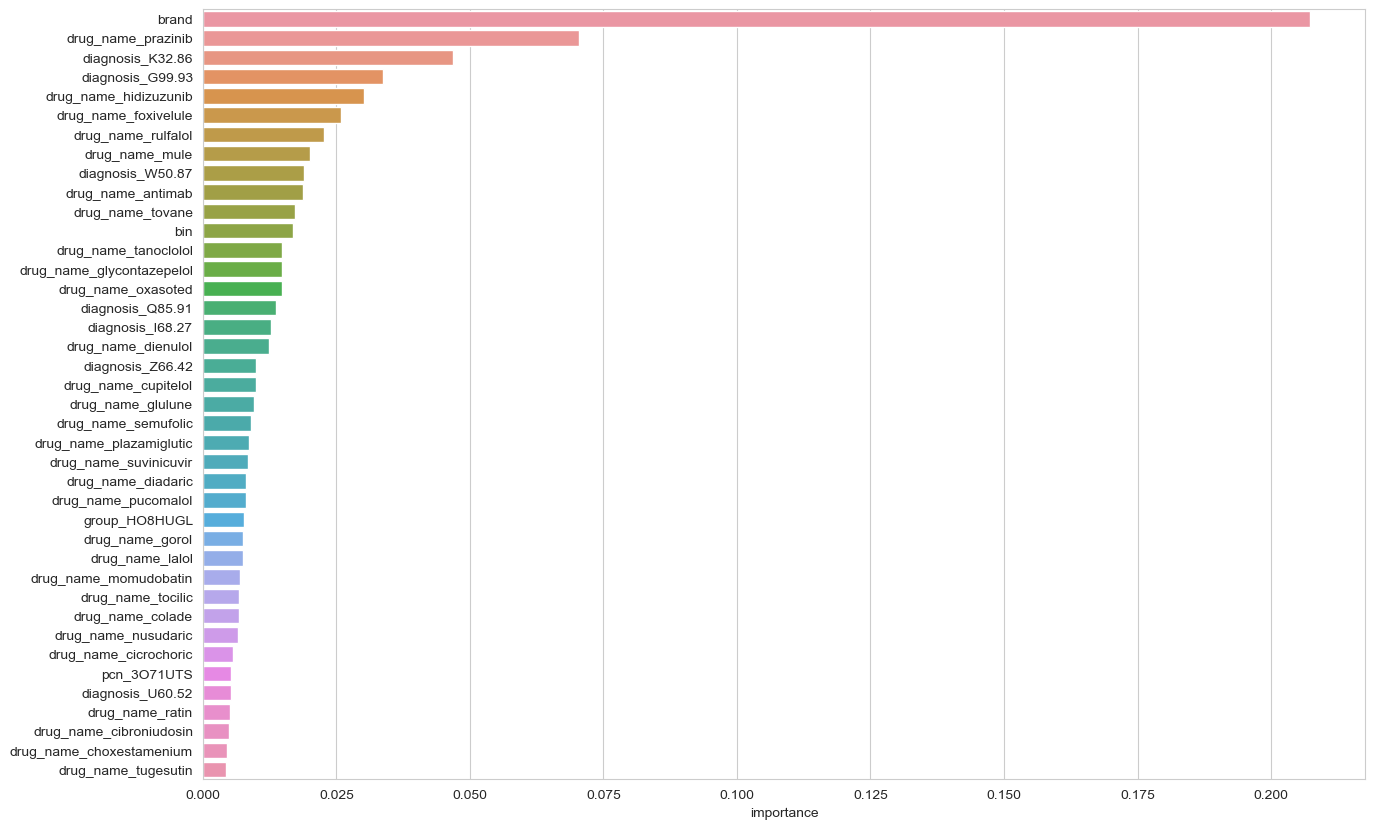

<Figure size 640x480 with 0 Axes>

In [27]:
# Plotting feature importance 
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=["importance"], index=X_train.columns)

importances.iloc[:,0] = BalancedRFC_model.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:40]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()
plt.savefig("featureimportance.png") #save as png

### try to see important features in the actual dataset 

In [36]:
# branded 0, generic 1; rejected 1, accepted 0
NoJan_df1.groupby(["brand", "rejected"]).count()

tx_date  pharmacy  diagnosis      bin      pcn    group  \
brand rejected                                                            
0     0         6385347   6385347    6385347  6385347  4764726  4584636   
      1          951222    951222     951222   951222   686963   696490   
1     0         4270991   4270991    4270991  4270991  3178495  3070234   
      1           21632     21632      21632    21632    14876    17047   

                patient_pay  drug_name  
brand rejected                          
0     0             6385347    6385347  
      1              951222     951222  
1     0             4270991    4270991  
      1               21632      21632

#### as we suspected more branded drugs were rejected as compared to generic ones

In [61]:
prazinib_df=NoJan_df1.loc[NoJan_df1["drug_name"] == "prazinib"]
prazinib_df.head(10)

,tx_date,pharmacy,diagnosis,bin,pcn,group,rejected,patient_pay,brand,drug_name
1019813,2022-02-01,Pharmacy #54,G51.87,691847,XH4T3,GOM8K0,0,10.72,1,prazinib
1019846,2022-02-01,Pharmacy #11,I68.27,664344,NaN,STGRDKR1J5RD,0,11.74,0,prazinib
1019854,2022-02-01,Pharmacy #30,I68.27,664344,DY4B,NaN,0,17.11,0,prazinib
1019873,2022-02-01,Pharmacy #52,I68.27,96934,S76J7V6,NaN,0,13.93,0,prazinib
1019882,2022-02-01,Pharmacy #17,I68.27,664344,NaN,52H8KH0F83K,0,10.63,1,prazinib
1019893,2022-02-01,Pharmacy #56,I68.27,571569,NaN,NaN,0,10.84,1,prazinib
1019931,2022-02-01,Pharmacy #21,I68.27,96934,S76J7V6,NaN,0,10.44,1,prazinib
1019938,2022-02-01,Pharmacy #7,G51.87,691847,XH4T3,GOM8K0,0,15.55,0,prazinib
1019945,2022-02-01,Pharmacy #9,I68.27,322463,T52GV,EVD4X5,0,10.72,1,prazinib
1019967,2022-02-01,Pharmacy #27,I68.27,539437,CG3ZWQ,NaN,0,7.27,0,prazinib


##### interesting that same drug such as prazinib was classified as generic and branded, however, their patient payment were comparable. 

In [62]:
prazinib_df.groupby(["brand", "rejected"]).count()

,,tx_date,pharmacy,diagnosis,bin,pcn,group,patient_pay,drug_name
brand,rejected,,,,,,,,
0,0,526395,526395,526395,526395,397781,380168,526395,526395
1,0,535607,535607,535607,535607,403978,386698,535607,535607


In [51]:
rowdata_df.loc[rowdata_df["drug"] == "branded prazinib"]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay
9,2022-01-02,Pharmacy #28,I68.27,branded prazinib,664344,CS8580,NaN,False,11.74
45,2022-01-02,Pharmacy #5,G51.87,branded prazinib,664344,BIZF,QK6BI1N61,False,11.62
86,2022-01-02,Pharmacy #38,I68.27,branded prazinib,725700,327CKV,IOEAN1DWVV3Y,False,11.40
96,2022-01-02,Pharmacy #15,I68.27,branded prazinib,322463,3O71UTS,NaN,False,12.22
102,2022-01-02,Pharmacy #23,I68.27,branded prazinib,96934,S76J7V6,NaN,False,13.93
...,...,...,...,...,...,...,...,...,...
13910179,2022-12-30,Pharmacy #52,I68.27,branded prazinib,725700,1UQC,NaN,False,13.39
13910204,2022-12-30,Pharmacy #57,I68.27,branded prazinib,691847,NC7EN,NaN,False,17.91
13910207,2022-12-30,Pharmacy #55,I68.27,branded prazinib,757349,RM0HB,SJVO3GXUURRGO,False,10.86
13910230,2022-12-30,Pharmacy #18,I68.27,branded prazinib,322463,3O71UTS,NaN,False,12.22


In [52]:
rowdata_df.loc[rowdata_df["drug"] == "generic prazinib"]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay
14,2022-01-02,Pharmacy #24,I68.27,generic prazinib,691847,NC7EN,NaN,False,10.72
21,2022-01-02,Pharmacy #22,G51.87,generic prazinib,691847,ZQPX,KZWQDIHCLLHD1,False,10.72
27,2022-01-02,Pharmacy #54,I68.27,generic prazinib,725700,327CKV,IOEAN1DWVV3Y,False,10.62
104,2022-01-02,Pharmacy #0,I68.27,generic prazinib,718350,J5DT8,IX6P0,False,10.59
105,2022-01-02,Pharmacy #30,I68.27,generic prazinib,664344,NaN,ZX2QUWR,False,13.33
...,...,...,...,...,...,...,...,...,...
13910178,2022-12-30,Pharmacy #8,S15.62,generic prazinib,757349,MSCXSG,DGLGRYP,False,10.63
13910182,2022-12-30,Pharmacy #6,I68.27,generic prazinib,322463,NaN,HO8HUGL,False,10.12
13910184,2022-12-30,Pharmacy #32,G51.87,generic prazinib,571569,KB38N,6BYJBW,False,10.84
13910211,2022-12-30,Pharmacy #16,I68.27,generic prazinib,571569,KB38N,6BYJBW,False,10.84


In [56]:
NoJan_df1.groupby(["bin", "rejected"]).count()

tx_date  pharmacy  diagnosis      pcn    group  patient_pay  \
bin    rejected                                                                
96934  0          640111    640111     640111   640111    75192       640111   
       1           60038     60038      60038    60038     9278        60038   
160389 0          204641    204641     204641   204641   204641       204641   
       1           23255     23255      23255    23255    23255        23255   
322463 0         1878945   1878945    1878945  1127791  1236430      1878945   
       1          192316    192316     192316    97860   139807       192316   
539437 0          406455    406455     406455    62263   384984       406455   
       1           31471     31471      31471     4598    29890        31471   
571569 0          604343    604343     604343   531913   542111       604343   
       1           45423     45423      45423    40397    41112        45423   
664344 0         3032414   3032414    3032414  1754081  2325716      3032414   
       1          277270    277270     277270   155742   216977       277270   
691847 0         1055787   1055787    1055787   967504   694070      1055787   
       1           95671     95671      95671    87822    63975        95671   
718350 0          206500    206500     206500   206500   206500       206500   
       1           17014     17014      17014    17014    17014        17014   
725700 0         1539833   1539833    1539833  1435759  1039232      1539833   
       1          135218    135218     135218   125244    90496       135218   
756120 0          141315    141315     141315   141315        0       141315   
       1           13445     13445      13445    13445        0        13445   
757349 0          730133    730133     730133   655482   730133       730133   
       1           60275     60275      60275    54966    60275        60275   
956971 0          215861    215861     215861   215861   215861       215861   
       1           21458     21458      21458    21458    21458        21458   

                   brand  drug_name  
bin    rejected                      
96934  0          640111     640111  
       1           60038      60038  
160389 0          204641     204641  
       1           23255      23255  
322463 0         1878945    1878945  
       1          192316     192316  
539437 0          406455     406455  
       1           31471      31471  
571569 0          604343     604343  
       1           45423      45423  
664344 0         3032414    3032414  
       1          277270     277270  
691847 0         1055787    1055787  
       1           95671      95671  
718350 0          206500     206500  
       1           17014      17014  
725700 0         1539833    1539833  
       1          135218     135218  
756120 0          141315     141315  
       1           13445      13445  
757349 0          730133     730133  
       1           60275      60275  
956971 0          215861     215861  
       1           21458      21458